In [1]:
from os import listdir
from os.path import isfile, join

import numpy as np
import cv2
import matplotlib.pyplot as plt

from segmentation_models import PSPNet
from segmentation_models import FPN
from segmentation_models import Unet
from segmentation_models.segmentation_models.backbones import get_preprocessing

from keras import backend as K
import keras

import spacexyz
%load_ext autoreload
%autoreload 2

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

## Load data

In [2]:
# path_to_data = '/scratch2/peilun/SpaceXYZ/PngData/oxygen_plans/'
path_to_data = '/scratch2/peilun/SpaceXYZ/PngData/eko_plans'
# path_to_label = '/scratch2/peilun/val_types/labels'

num_classes = 1+7

In [3]:
data_files = spacexyz.path2filelist(path_to_data)
n_samples = len(data_files)
input_size = (512, 512, 3)
# X_ = np
print('Num of images: ', n_samples)

Num of images:  49


In [6]:
print("reading in ", n_samples, " samples...")
X_ = np.zeros([n_samples, *input_size]).astype(np.uint8)
remember_size = np.zeros([n_samples, 3])
for i in range(n_samples):
    print(i, end='. ')
    t_image = cv2.imread(join(path_to_data, data_files[i]))
    remember_size[i, :,] = t_image.shape
#     t_label = cv2.imread(join(train_label_path, train_labels[i]))
    X_[i,:,:,:] = cv2.resize(t_image, input_size[:2])
#     y_train[i,:,:] = cv2.resize(t_label[:,:,0], output_size[:2], interpolation=cv2.INTER_NEAREST)
# y_train = keras.utils.to_categorical(y_train, num_classes=7, dtype='float32')
remember_size = remember_size.astype(np.int64)

reading in  49  samples...
0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 

## Load model

In [7]:
path_to_model = '/scratch2/peilun/SpaceXYZ/Unet_epoch_100.h5'
model = keras.models.load_model(path_to_model)

## Prediction

In [8]:
pred = model.predict(X_, batch_size=None, verbose=1, steps=None)

49/49 [==============================] - 5s 112ms/step


(49, 512, 512)


True

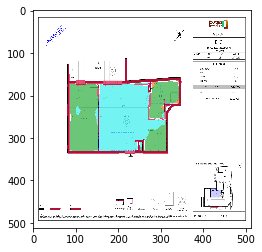

In [9]:
import imgaug as ia
from imgaug import augmenters as iaa

ind = spacexyz.onehot2ind(pred)
print(ind.shape)

k = 14
label = ind[k,:,:]
segmap = label.astype(np.int32)
segmap = ia.SegmentationMapOnImage(segmap, shape=(512, 512), nb_classes=num_classes)
plt.imshow(segmap.draw_on_image(X_[k,:,:,:]))
cv2.imwrite('messigray.png',segmap.draw_on_image(X_[k,:,:,:]))

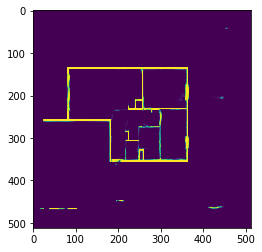

In [10]:
plt.imshow(pred[0,:,:,1])
plt.imsave('wall.png', pred[0,:,:,1])

## Save segmentation

In [11]:
import numpy as np
import h5py

In [114]:
pred_labels = []
for i in range(ind.shape[0]):
    print(ind[i,:,:].shape)
    print(remember_size[i,:2])
#     ind_original_size =  cv2.resize(ind[i,:,:], tuple(remember_size[i,:2]), interpolation=cv2.INTER_LINEAR)
    ind_original_size =  cv2.resize(ind[i,:,:], tuple(remember_size[i,:2]))
    pred_labels.append(ind_original_size)

(512, 512)
[3309 2339]


error: OpenCV(3.4.4) /io/opencv/modules/imgproc/src/resize.cpp:3662: error: (-215:Assertion failed) func != 0 in function 'resize'


True

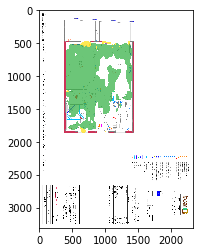

In [92]:


k=83
label = pred_labels[k]
segmap = label.astype(np.int32)
segmap = ia.SegmentationMapOnImage(segmap, shape=(512, 512), nb_classes=1+6)
# plt.imshow(segmap.draw_on_image(X_[k,:,:,:]))
plt.imshow(segmap.draw_on_image(t_image))
cv2.imwrite('messigray.png',segmap.draw_on_image(X_[k,:,:,:]))

In [12]:
h5f = h5py.File('oxygen_plans_new.h5', 'w')
h5f.create_dataset('oxygen_plans', data=pred)
h5f.close()

In [13]:
h5f = h5py.File('oxygen_plans.h5','r')
b = h5f['oxygen_plans'][:]

In [14]:
b.shape

(147, 512, 512, 7)

In [72]:
c = list()

In [75]:
c.append(np.array([1, 2]))

In [78]:
c.append(np.array([2, 3,4]))

In [79]:
c

[array([1, 2]), array([1, 2]), array([2, 3, 4])]